Задания:
1. Найти и выделить область, откуда совершается наибольшее кол-во поездок.
Область можно определять любой формы и размера. Визуализация на карте приветствуется (хитмап + выделенная область).
2. Для области из пункта 1 построить модель по предсказанию кол-ва поездок из этой области на час вперед.
Baseline - в качестве предсказания использовать предыдущее значение. Желательно побить baseline своей моделью.
Метрику выбираете сами.

То есть TARGET можно составить, после выделения интересующей области, сгруппировав время в часовые интервалы и считая количество записей (там дальше уже разбить на трейн и тест)
А Baseline модель просто берет предсказания с предыдущего часового интервала

## Modules and configs

In [1]:
import numpy as np
import pandas as pd
import gc
import time
import warnings
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

In [3]:
# для визуализации
import gmaps
import local_settings #API keys
gmaps.configure(api_key=local_settings.GOOGLE_API_KEY)


In [4]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Load data

In [5]:
%%time
file_path = '../input/'
data_types = {
    'tpep_pickup_datetime': 'object',
    'pickup_longitude': 'float32',
    'pickup_latitude' : 'float32'
}
data_original = pd.read_csv(f'{file_path}yellow_tripdata_2015.csv', dtype=data_types,
                            parse_dates = ['tpep_pickup_datetime'], infer_datetime_format=True, index_col=0)

C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 1min 42s


## Clean data

In [6]:
%%time
## Data cleaning
# Latitudes must lie between -90 and 90
# Longitudes are expressed as a float between -180 and +180
data_original.loc[data_original['pickup_longitude']<-180,'pickup_longitude'] =\
    data_original.loc[data_original['pickup_longitude']<-180,'pickup_longitude']/10

Wall time: 540 ms


In [7]:
# drop points with longitude 0
data = data_original.loc[data_original['pickup_longitude']!=0,:]

In [8]:
del data_original
gc.collect()

7

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68033640 entries, 0 to 69006886
Data columns (total 3 columns):
tpep_pickup_datetime    datetime64[ns]
pickup_longitude        float32
pickup_latitude         float32
dtypes: datetime64[ns](1), float32(2)
memory usage: 1.5 GB


## Preprocess data

In [10]:
%%time
data['month'] = data.tpep_pickup_datetime.dt.month.astype(np.uint8)
data['weekday'] = data.tpep_pickup_datetime.dt.weekday.astype(np.uint8)
data['week'] = data.tpep_pickup_datetime.dt.week.astype(np.uint8)
data['day'] = data.tpep_pickup_datetime.dt.day.astype(np.uint8)
data['hour'] = data.tpep_pickup_datetime.dt.hour.astype(np.uint8)

Wall time: 24.7 s


## Select zone to visualize and predict

In [11]:
%%time
data['total_count'] = data.groupby(['pickup_latitude', 'pickup_longitude'])['tpep_pickup_datetime'].\
                                                                    transform('count').astype(np.uint32)



Wall time: 1min


In [12]:
data.head()

,tpep_pickup_datetime,pickup_longitude,pickup_latitude,month,weekday,week,day,hour,total_count
0,2015-07-01,-73.994156,40.751125,7,2,27,1,0,106
1,2015-07-01,-73.984657,40.768486,7,2,27,1,0,3
2,2015-07-01,-73.978889,40.762287,7,2,27,1,0,8
3,2015-07-01,-73.992790,40.742760,7,2,27,1,0,10
4,2015-07-01,-73.912430,40.769810,7,2,27,1,0,1


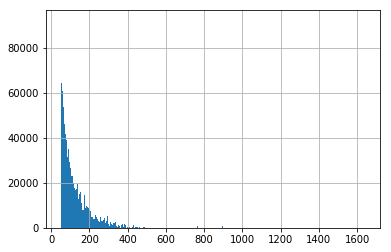

In [13]:
data[data.total_count >= 50].total_count.hist(bins=500)

In [14]:
%%time
data_mod = data[data.total_count >= 50]
print(data_mod.shape)
print(data_mod.head())

(1388801, 9)
   tpep_pickup_datetime  pickup_longitude  pickup_latitude  month  weekday  \
0   2015-07-01 00:00:00        -73.994156        40.751125      7        2   
12  2015-07-01 00:00:02        -73.862762        40.769035      7        2   
16  2015-07-01 00:00:02        -73.871002        40.773750      7        2   
24  2015-07-01 00:00:06        -73.873039        40.774101      7        2   
71  2015-07-01 00:00:15        -73.873032        40.774082      7        2   

    week  day  hour  total_count  
0     27    1     0          106  
12    27    1     0           95  
16    27    1     0          133  
24    27    1     0          185  
71    27    1     0          110  
Wall time: 260 ms


In [15]:
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1388801 entries, 0 to 69006854
Data columns (total 9 columns):
tpep_pickup_datetime    1388801 non-null datetime64[ns]
pickup_longitude        1388801 non-null float32
pickup_latitude         1388801 non-null float32
month                   1388801 non-null uint8
weekday                 1388801 non-null uint8
week                    1388801 non-null uint8
day                     1388801 non-null uint8
hour                    1388801 non-null uint8
total_count             1388801 non-null uint32
dtypes: datetime64[ns](1), float32(2), uint32(1), uint8(5)
memory usage: 43.7 MB


Исследовать будем те координаты, в которых за время наблюдений в датасете было более пятидесяти приездов такси (два аэропорта, вокзал и вблизи музея на Манхэттене).

## Visualization

In [16]:
locations = data_mod[['pickup_latitude', 'pickup_longitude']].drop_duplicates().reset_index(drop=True)
len(locations)

15191

In [17]:
locations = list(set(zip(list(locations['pickup_latitude']), list(locations['pickup_longitude']))))
len(locations)

15191

In [18]:

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, max_intensity = 100, point_radius = 5))
fig

Figure(layout=FigureLayout(height='420px'))

## Model making

In [19]:
%%time
data_mod['TARGET'] = data_mod.groupby(['month', 'day', 'hour'])['tpep_pickup_datetime'].\
                                                                    transform('count').astype(np.uint32)

Wall time: 285 ms


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
dataset = data_mod[['weekday', 'week', 'month', 'day', 'hour', 'TARGET']].drop_duplicates().reset_index(drop=True)
dataset.shape

(4416, 6)

In [21]:
dataset['naive'] = dataset['TARGET'].shift().fillna(method='bfill').astype(np.uint32)

In [22]:
dataset.head()

,weekday,week,month,day,hour,TARGET,naive
0,2,27,7,1,0,318,318
1,2,27,7,1,1,54,318
2,2,27,7,1,2,24,54
3,2,27,7,1,3,19,24
4,2,27,7,1,4,11,19


In [23]:
train_proportion = 0.8
split_index_num = np.uint32(round(dataset.shape[0]*train_proportion, 0))

In [24]:
X, y, test, y_test, y_naive, y_naive_train = (dataset[:split_index_num].drop(['TARGET', 'naive'], axis=1),
                        dataset[:split_index_num]['TARGET'],
                        dataset[split_index_num:].drop(['TARGET', 'naive'], axis=1),
                        dataset[split_index_num:]['TARGET'],
                        dataset[split_index_num:]['naive'],
                        dataset[:split_index_num]['naive'])

In [25]:
def cv_scores(X, y, test, y_naive_train, num_folds, params, verbose = -1,
              early_stopping = 300,
              train_full_model=False,
              seed = 42):
    warnings.simplefilter('ignore')
    
    valid_pred = np.zeros(X.shape[0])
    
    test_prediction = pd.DataFrame(index = test.index)
    
    
    iterations = np.zeros(num_folds, dtype=np.uint16)
    train_scores = np.zeros(num_folds, dtype=np.float32)
    fold_scores = np.zeros(num_folds, dtype=np.float32)

    
    tscv = TimeSeriesSplit(n_splits=num_folds)
    n_fold = 0
    for train_index, valid_index in tscv.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        print(n_fold, X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
        
        rgr = LGBMRegressor(importance_type = 'gain', random_state = seed, **params)
        rgr.fit(X_train, y_train, 
                eval_set = [(X_train, y_train), (X_valid, y_valid)], eval_metric = 'rmse',
                eval_names = [f'{n_fold}_train', f'{n_fold}_valid'],
                verbose = verbose, early_stopping_rounds = early_stopping)
        iterations[n_fold] = rgr.best_iteration_
        valid_pred[[valid_index]] = rgr.predict(X_valid, num_iteration = rgr.best_iteration_)#[:, 1]
        test_prediction[n_fold] = pd.Series(rgr.predict(test, num_iteration = rgr.best_iteration_), index = test.index)#[:, 1])
        train_scores[n_fold] = rgr.evals_result_[f'{n_fold}_train']['rmse'][rgr.best_iteration_-1]
        fold_scores[n_fold] = np.sqrt(mean_squared_error(y_valid, valid_pred[[valid_index]]))
        
        
        print('Fold %2d train rmse: %.6f, valid rmse: %.6f; naive rmse on valid: %.6f; best iteration %5d;' % (n_fold,
                  train_scores[n_fold],
                  fold_scores[n_fold],
                  np.sqrt(mean_squared_error(y_valid, y_naive_train.iloc[valid_index])), 
                  iterations[n_fold]))

        n_fold += 1
        
            
    if train_full_model:
        print(f'Full train learning for {iterations[num_folds-1]+20} iterations',
              'started at', time.ctime())
        params['n_estimators'] = iterations[num_folds-1]+20
        rgr_full = LGBMRegressor(importance_type = 'gain', random_state = seed, **params)
        rgr_full.fit(X, y, verbose = verbose)
        test_prediction[n_fold] = pd.Series(rgr_full.predict(test), index = test.index)

    
    return fold_scores, test_prediction


In [26]:
lgbm_params = {
            'objective': 'regression',
            'boosting_type': 'gbdt',
            'nthread': 4,
            'n_estimators': 10000,#10000
            'learning_rate': .05,
            'num_leaves': 600,#30
            'max_depth': -1,
            'reg_lambda': 100,
            'silent': -1,
            'seed': RANDOM_STATE,
            'verbose': -1
}

scores, test_pred = cv_scores(X, y, test, y_naive_train, 5,
              lgbm_params, verbose = 100,
              early_stopping = 300,
              train_full_model=True,
              seed = 42)

0 (593, 5) (588, 5) (593,) (588,)
Training until validation scores don't improve for 300 rounds.
[100]	0_train's rmse: 61.6637	0_valid's rmse: 83.4622
[200]	0_train's rmse: 48.2404	0_valid's rmse: 75.1474
[300]	0_train's rmse: 43.5784	0_valid's rmse: 73.0274
[400]	0_train's rmse: 41.2128	0_valid's rmse: 72.2978
[500]	0_train's rmse: 39.5254	0_valid's rmse: 72.282
[600]	0_train's rmse: 38.1853	0_valid's rmse: 71.9085
[700]	0_train's rmse: 37.1916	0_valid's rmse: 71.8421
[800]	0_train's rmse: 36.4388	0_valid's rmse: 71.8013
[900]	0_train's rmse: 35.7943	0_valid's rmse: 71.7503
[1000]	0_train's rmse: 35.2497	0_valid's rmse: 71.8616
[1100]	0_train's rmse: 34.6932	0_valid's rmse: 71.9413
Early stopping, best iteration is:
[860]	0_train's rmse: 36.0532	0_valid's rmse: 71.7271
Fold  0 train rmse: 36.053246, valid rmse: 71.727135; naive rmse on valid: 107.173765; best iteration   860;
1 (1181, 5) (588, 5) (1181,) (588,)
Training until validation scores don't improve for 300 rounds.
[100]	1_tra

## Results

### Baseline model RMSE metric

In [27]:
rmse_naive = np.sqrt(mean_squared_error(y_test, y_naive))
print(rmse_naive)

120.17915561807553


### Trained (without validation fold) lightgbm model  RMSE  metric

In [28]:
np.sqrt(mean_squared_error(y_test, test_pred[4]))

109.37214122612241

### Fully trained lightgbm model  RMSE metric

In [29]:
np.sqrt(mean_squared_error(y_test, test_pred[5]))

97.92452981287609